## Event detection: New York in the Influenza pandemic (1918-19) through historic newspapers

### Table of Contents

#### [Introduction](#introduction)
#### [Data Collection](#collection)
&nbsp;&nbsp;&nbsp;&nbsp;[Checkpoint 1](#cp1): Extracted list of URLs
#### [Data Processing](#processing)
&nbsp;&nbsp;&nbsp;&nbsp;[Checkpoint 2](#cp2): Extracted text
<br>&nbsp;&nbsp;&nbsp;&nbsp;[Checkpoint 3](#cp3): Summarized text
#### [Data Visualization](#visualization)
&nbsp;&nbsp;&nbsp;&nbsp;[Checkpoint 4](#cp4): Partial results
#### [Conclusion](#conclusion)
#### [Bibliography](#bibliography)

<a id='introduction'></a>

## Introduction

As Historians, we are interested in the story that data can tell us. Until recently, the only way a Historian could collect data was manually, often involving the visit to archives, where they would hope to find and access the needed data as well as take notes (and, more recently, pictures), spending countless hours in a very laborious process, possibly having to submit themselves to administrative hurdles (Müller, 2013). The development of the Optical Character Recognition (OCR) technology, in the context of growing streams of data populating the Internet, is a potential game-changer. Paired with other techniques from the field of Machine Learning, the technology makes possible the study of large corpora of written text in a way that was not possible with any other technology previous available.

We thought this coursework would be a great opportunity to explore the potential of OCR paired with Natural Language Processing (NLP), making use especially of written media (namely newspapers).

Additionally, the current public health emergency of global proportions originated in the outbreak of the new Sars-Cov-2 virus has been an inspiration for us to work creatively with data with the purpose of finding potentially helpful insights. In that spirit, we decided to explore the combination of the aforementioned aspects: OCR, NLP, written media, and pandemic.

We have searched for datasets that would offer the possibility for such analysis. One possibility would have been to use archives from different media houses where they are available, and then creating a web crawler that would run on parameters customized for each website (see assignment here: [link](https://learn.london.ac.uk/mod/forum/discuss.php?d=12366)), i.e. make use of XPath to extract relevant parts of the webpage.

However, our research on datasets has led us to a very interesting initiative created and maintained by the National Digital Newspaper Program of the United States, _Chronicling America_ (Fuller-Seeley, 2008). The website exposes data "about historic newspapers and select digitized newspaper pages", with the goal of developing "an Internet-based, searchable database of U.S. newspapers" ("About Chronicling America", 2021). 

Before deciding to use this dataset for our project, our first concern was whether or not it is allowed to do so. Fortunately, the usage of this data is encouraged by the website maintainers (Butterhof, Thomas, & Yarasavage, 2021). One of their initiatives was a data challenge in 2018 ("NEH Announces the Winners of the Chronicling America Data Challenge", 2021). 

Technically, crawling the archive utilizing a HTML web crawler was possible, but the website also offers access to its database via an Application Programming Interface (API) that exposes, among others, files in JSON format ([link here](https://chroniclingamerica.loc.gov/about/api/)), which is a lightweight data interchange format  and therefore preferable. Since here we could find the information we needed, this is the path we have decided to take. Starting on this page _https://chroniclingamerica.loc.gov/newspapers.json_, we can go through the file structure (such as Start Url -> Newspaper -> Issue -> Page). This simplifies the process of data acquisition. 

If compared to the web-crawling of structured news websites, however, in which there are ways to extract only some areas of the page, here we need to download and process the whole content of every page of interest. It is not possible to select the areas of interest in the page text. This aspect of the dataset is coupled with a few others that have important implications for our project. For instance, the unstructured text does not allow us to extract actual articles (a body of text with at least title, publish date, ingress, author, and content etc.), but only a full page of the actual newspaper, which not only likely will contain more than one article, but also will have sometimes parts of articles (continuing the text from the previous page or being continued in the next page). 

The data quality is another important factor to mention. When we started this project, it was clear that there would be issues regarding OCR quality. For this reason, one of the most important steps in our project is the text cleaning. Throughout the project, we discuss how this is approached, and we problematize the results in the Conclusion.

The data selection is done based on the timeline of interest and the size of the dataset. We are interested in data from March, 1918, which is when the outbreaks of a "flu-like illness" first appear in the United States, until April, 1919, when the pandemic was under control in the U.S. ("1918 Pandemic Influenza Historic Timeline", 2021). This period overlaps with the participation of the U.S. (April, 1917 to November, 1918) in the First World War. What is more, the size of the dataset has led us to select New York as the geographic location on which to focus - attribute available as metadata in their JSON API. If our dataset would have comprised of the whole U.S., it might have taken weeks to run this notebook. New York seemed like a natural choice, both due to its importance as a urban hub and, by extension, to a proportionally bigger dataset in relation to other states.

Nonetheless, note that the dataset is still very large (about 25,000 pages), hence we provide you with "checkpoints" throughout the whole notebook and make available code for sampling where it might be suitable. These checkpoints will pull the data from the CSV files submitted along with this notebook.

In [104]:
# import libraries and load models

import jmespath
import requests
from urllib.request import urlopen
import json
import re
import pandas as pd
import numpy as np
from lxml import etree
import spacy
import nltk
import heapq
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/felipemarineli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felipemarineli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id='collection'></a>

## Data Collection

Our entry point to the website is their list of newspapers (in JSON format). We extract the content of this page and, for each of the next steps, select the data of interest.

In [105]:
# This is our "start url"
url = 'https://chroniclingamerica.loc.gov/newspapers.json'

# Now we want a JSON representation of the contents of that page, i.e. the newspaper titles available in the archive
# with their respective URL links
newspapers = requests.get(url).json()

For each newspaper title, we get content like the following:

In [106]:
# Checking the first newspaper title
list(newspapers.items())[0][1][0]

{'lccn': 'sn86072192',
 'url': 'https://chroniclingamerica.loc.gov/lccn/sn86072192.json',
 'state': 'Alabama',
 'title': 'The age-herald. [volume]'}

The next step is visiting each <b>newspaper</b> page in order to search for the issues in which we are interested. First we can already filter the newspapers by location.

In [107]:
# Filter the results by state New York
newspaper_urls = jmespath.search("newspapers[?state == 'New York'].url", newspapers)

In [108]:
newspaper_urls

['https://chroniclingamerica.loc.gov/lccn/sn84020097.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030193.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030483.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030311.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030312.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83045774.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030313.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030213.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030212.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030214.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83035526.json',
 'https://chroniclingamerica.loc.gov/lccn/sn86071738.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030430.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030273.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030272.json',
 'https://chroniclingamerica.loc.gov/lccn/sn83030431.json',
 'https://chroniclingamerica.loc.gov/lcc

The next step is to visit each of the publications and extract the <b>issues</b> in which we are interested. In this depth we also need to apply some filtering: once we visit each publication URL and have access to their content, we gain access to each publication's start and end date. Hence before extracting any link on that page, we check whether or not it could possibly have content in the date range we are interested, otherwise we do not crawl any links.

When we decide to keep a publication, we can look up the next information of interest: the issued date for each issue. Here too we only want to keep the issues within the relevant date range.

After passing all these checks, the issue URL is crawled. There we have access to the issue <b>pages</b>. Different file types are available for use. The optimal type for our purposes is the OCR data. We finally crawl the OCR version (plain text) of each page.

In [754]:
# The list below will be the list to populate with the document URLs we want to visit and extract.
doc_urls = []

# Iterate through the list of the URLs that lead to the data on each newspaper.
for url in newspaper_urls:
    # The list issue_urls will contain the URLs for the issues of every visited newspaper.
    issue_urls = []
    # Visit the newspaper URL and save its contents as JSON.
    newspaper = requests.get(url).json()
    # Search for the start and the end year available for this newspaper.
    start_year = jmespath.search('start_year', newspaper)
    end_year = jmespath.search('end_year', newspaper)
    # Skip the URL if the year is incomplete or is not a valid number.
    try:
        end_year = int(end_year)
        start_year = int(start_year)
    except ValueError:
        continue
    # Skip the URL if the start year is later than 1919 (after the most important waves of the pandemic) or 
    # the end year is smaller than 1918.
    if (start_year > 1919) or (end_year < 1918):
        continue    
    # Iterate through the issue URLs for the given newspaper.
    for issue in newspaper['issues']:  
        # Extract the issue date
        date_issued = issue['date_issued']
        # Skip if the date is outside the range of interest -
        # additional computation for validation was not necessary in this step.
        if date_issued < '1918-03-01':
            continue
        if date_issued > '1919-04-30':
            continue
        # Append the URL to the list of issue URLs that we need to visit.
        issue_urls.append(issue['url'])
    
    # Iterate through the issue URLs
    for issue_url in issue_urls:
        # Visit the issue URL and extract its contents as JSON.
        try:
            r = requests.get(issue_url).json()
        # Exception handler to avoid breaking the program due to malformed JSON files.
        except ValueError:
            continue
        
        # For performance purposes, I decided not to visit the page URLs below in order to get the link for
        # the OCR text file, since it can be inferred from the parent URL. There is a clear performance/time
        # improvement this way.
        
        # Extract the URLs for each page of the issue
        page_urls = jmespath.search('pages[*].url', r)
        # Iterate through the page URLs
        for page_url in page_urls:
            # Assemble the OCR URL
            OCR_url = re.sub('\.json', '/ocr.txt', page_url)
            # Append it to the list of document URLs to extract
            doc_urls.append(OCR_url)
            

<a id='cp1'></a>

#### CHECKPOINT 1: Extracted list of URLs

In [109]:
### CHECKPOINT 1: Extracted list of URLs

#import itertools
#data = pd.read_csv('doc_urls.csv', usecols=[0]).values.tolist()
#doc_urls = list(itertools.chain.from_iterable(data))

In [110]:
print(f'This is the length of our dataset: {len(doc_urls)} page URLs.')

This is the length of our dataset: 25686 page URLs.


<a id='processing'></a>

## Data Processing

Next we create an `extract()` function that will be applied on every URL in a list of URLs. For each URL, it goes through the following steps:
- Visit the webpage;
- download and store its contents;
- extract the publish date of the page from the URL;
- save the results.

It returns a DataFrame for further processing.

In [8]:
from urllib.error import HTTPError

# This is the function to extract the contents of every page URL in OCR format.
def extract(url_list):
    # Compile a regular expression to extract the date of each page URL.
    date_regex = re.compile('\d{4}-\d{2}-\d{2}')
    # Create an empty list to populate.
    result = []
    
    # This is the nested function that will visit each URL and save the results as a string (it is OCR text).
    def crawl(url):
        # Create an empty string to populate
        text_string = ""
        try:
            # Open the URL
            response = urlopen(url)
            # Since it is a TXT file, we join it line by line to the empty string created above.
            for line in response:
                text_string += "".join(line.decode("utf-8"))
            return text_string
        # Some URLs would through an HTTPError because they were broken links. The exception handler is here for that.
        except HTTPError:
            pass
    
    # Now we iterate through each URL of the list of URLs
    for url in url_list:
        # Visit the page and extract the content using the function we just defined above.
        doc = crawl(url)
        # Use the compile date regular expression to extract the date.
        publish_date = re.search(date_regex, url).group(0)
        # Append all the extracted and partially processed information to the "result" list.
        result.append([url, publish_date, doc])
    
    # Transform the list into a DataFrame and return it
    return pd.DataFrame(result, columns=['url', 'publish_date', 'doc'])

In [9]:
### Warning: execution here may take a several hours. In order to facilitate reproducing the results, we suggest using
### a sample of the DataFrame, as shown below:

from random import sample
df = extract(sample(doc_urls, 100))

### Otherwise run on the whole dataset:
#df = extract(doc_urls)

<a id='cp2'></a>

#### CHECKPOINT 2: Extracted text

In [111]:
### CHECKPOINT 2: Extracted text

#df = pd.read_csv('extracted_doc_urls.csv', usecols=['url', 'publish_date', 'doc'])

One of the fundaments of our analysis will be the summarization of content. For every newspaper page, we perform substitutions in the content using regular expressions in order to fix broken text as a best-effort, and then make use of Inverse Document Frequency (IDF) in order to select the single sentence that has the highest total word-IDF in the page.

In [11]:
# This function will create a summary for each extracted page.
def summarize(text_string):
    
    # Firstly, we do some substitutions using the "re" module in order to process a cleaner text.
    
    # Replace digitys inside square brakets by a blank space.
    article_text = re.sub(r'\[[0-9]*\]', ' ', text_string)
    # Replace one or more blank spaces by only one black space.
    article_text = re.sub(r'\s+', ' ', article_text)
    # Replace any linebreak character by black space.
    article_text = re.sub(r'\n+', ' ', article_text)
    # Replace any non-letter by a blank space and assign it to a new variable (in order not to 
    # count digits when computing word frequencies).
    formatted_article_text = re.sub('[^a-zA-Z]', ' ', article_text)
    
    # Use the NLTK module in order to tokenize the text by sentences, and save them separately.
    sentence_list = nltk.sent_tokenize(article_text)
    # Store the list of stopwords from the NLTK module in order to improve the summarization results below.
    stopwords = nltk.corpus.stopwords.words('english')
    # Create an empty dictionary to populate with word frequencies.
    word_frequencies = {}
    # Calculate word frequencies (if they are not stopwords).
    for word in nltk.word_tokenize(formatted_article_text.lower()):
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1
    # Get the maximum word frequency.
    maximum_frequency = max(word_frequencies.values(), default=0)

    # Iterate over each unique word and calculate the Inverse Document Frequency (IDF).
    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frequency)
    # Create empty dictionary to calculate the score of each sentence based on the IDF results.
    sentence_scores = {}
    # Iterate through every sentence.
    for sent in sentence_list:
        # Iterate through every word in lower case.
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                # Filter out sentences longer than thirty words, which is an arbitrary but reasonable value to avoid
                # extremely long sentences that might be due to a bad OCR job, for instance.
                if len(sent.split(' ')) < 30:
                    # Store the scores of the word for the given sentence
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]
    # Return the element that has the larges score in the dictionary "sentence_scores"
    summary_sentences = heapq.nlargest(1, sentence_scores, key=sentence_scores.get)
    summary = ' '.join(summary_sentences)
    
    return summary        

In [12]:
# Apply the 'summarize' function and save the results to a new column in the DataFrame. Alternatively load
# the CSV from the checkpoint below instead.

df['summary'] = df['doc'].apply(summarize)

<a id='cp3'></a>

#### CHECKPOINT 3: Summarized text

In [155]:
### CHECKPOINT 3: Summarized text

#df = pd.read_csv('summarized_texts.csv', usecols=['url', 'publish_date', 'doc', 'summary'])

In [132]:
# Keep only summaries bigger than one character.
df = df[df['summary'].str.len() > 1]

Once we have the summary of each page based on IDF, we perform more robust cleaning on it. In the function below, we perform a few steps. They are based firstly on an exhaustive assessment of most common issues with this specific corpus - e.g. the letter "e" being recognized as the letter "o". Secondly, we make partial use of the algorithm exposed by Taghva et. al., 2021, for automatic removal of garbage strings, designed precisely to deal with historical texts subject to poor OCR data. The use of all additional rules will be considered for the final coursework, depending of which path we decide to take (see _Conclusion_). 

In [133]:
# This function further cleans the summary using regular expressions.

def clean_df(df):
    # Ensure every row in the 'summary' column is a string.
    df.summary = df.summary.astype(str)
    
    # Substitutions based on observations of the real results.
    df.summary = df.summary.str.replace(r'\s+tho\s+', ' the ')
    df.summary = df.summary.str.replace(r'Tho\s+', 'The ')
    df.summary = df.summary.str.replace(r'\s+camo\s+', ' came ')
    df.summary = df.summary.str.replace(r'\s+(ore|aro)\s+', ' are ')
    df.summary = df.summary.str.replace(r'\s+ho\s+', ' he ')
    df.summary = df.summary.str.replace(r'\s+Ho\s+', ' He ')
    df.summary = df.summary.str.replace(r'\s+ot\s+', ' of ')
    df.summary = df.summary.str.replace(r'Xing\s+', 'King ')
    df.summary = df.summary.str.replace(r'\s+maybo\s+', ' maybe ')
    df.summary = df.summary.str.replace(r'Maybo\s+', 'Maybe ')
    df.summary = df.summary.str.replace(r'\s+scaro\s+', ' scare ')
    df.summary = df.summary.str.replace(r'Scaro\s+', 'Scare ')
    df.summary = df.summary.str.replace(r'\s+wo\s+', ' we ')
    df.summary = df.summary.str.replace(r'Wo\s+', 'We ')
    df.summary = df.summary.str.replace(r'\s+hav[no]\s+', ' have ')
    df.summary = df.summary.str.replace(r'\s+\w{3}haps\s+', ' perhaps ')
    df.summary = df.summary.str.replace(r'\s+Iteglment\s+', ' Regiment ')
    df.summary = df.summary.str.replace(r'\s+intcrvlow\s+', ' interview ')
    df.summary = df.summary.str.replace(r'\s+removod\s+', ' removed ')
    df.summary = df.summary.str.replace(r'\s+leaguo\s+', ' league ')
    df.summary = df.summary.str.replace(r'\s+nnd\s+', ' and ')

    # If a summary starts in lowercase, it is garbage:
    lowercase = re.compile('^[a-z]+')
    df = df[~df.summary.str.contains(lowercase, regex=True)]
    
    # If a word is longer than 40 characters, it is garbage:
    long_strings = re.compile('\s+\w{40,}\s+')
    df = df[~df.summary.str.contains(long_strings, regex=True)]
    
    # If a word has more than 3 identical characters in a row, it is garbage:
    identical_chars = re.compile('(.)\1{3,}')
    df = df[~df.summary.str.contains(identical_chars, regex=True)]

    # If a summary begins with punctuation, it is garbge:
    starts_with_punctuation = re.compile('^[\.\?!,><]+')
    df = df[~df.summary.str.contains(starts_with_punctuation, regex=True)].reset_index()
    
    # Strip off the first and last characters of a string. If there are two distinct punctuation characters in the
    # result, then the string is garbage, so 'a,bc/defg' is garbage, 'ab,cde,fg' is not.
    broken_word = re.compile('[!\?\/\:;<>%^~`´"]+')
    indexes_to_drop = []
    for i, row in df.iterrows():
        for word in nltk.word_tokenize(row['summary'].lower()):
            if re.search(broken_word, word[1:-1]):
                indexes_to_drop.append(i)
    rows = df.index[[indexes_to_drop]]
    df = df.drop(rows).reset_index().drop(columns='level_0')
    
    # If a string begins and ends with a lowercase letter, then if the string contains an uppercase letter anywhere 
    # in between, then it is removed as garbage:
    highercase_within_string = re.compile('[A-Z]')
    indexes_to_drop = []
    for i, row in df.iterrows():
        for word in nltk.word_tokenize(row['summary']):
            if re.search(highercase_within_string, word[1:-1]):
                indexes_to_drop.append(i)
    rows = df.index[[indexes_to_drop]]
    df = df.drop(rows)   

    # Remove ads as best as possible - they would be an interesting case to look at on their own.
    regex_ads = re.compile('furnish.*|-room|\$\d\.\d{2}|per[\s+\d+]?\s+lb|\d+[\s+]?c')
    df = df[~df.summary.str.contains(regex_ads, regex=True)]
    
    return df

# Apply the function.
df = clean_df(df)

/Users/felipemarineli/opt/anaconda3/envs/submission/lib/python3.8/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Users/felipemarineli/opt/anaconda3/envs/submission/lib/python3.8/site-packages/pandas/core/indexes/base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


On every summary, we apply the `nlp` function from `spacy`. This will give us access to the word vectors.

In [134]:
# Empty list for the results of calling nlp() on the summaries.
corpus = []

# Iterate through the summaries.
for summary in df.summary:
    # Call nlp()
    doc = nlp(summary)
    # Append this result to the 'corpus' list.
    corpus.append(doc)

# Save results in new column
df['sent'] = corpus

The two functions below are another central aspect of our analysis. For any subset of sentences, we want to extract the most representative sentence among all. For this, we transform all sentences in numeric vectors and calculate the mean value. Following that, through the use of the `pairwise_distances_argmin_min` function from scikit-learn, we select the sentence closest to that value.

In [135]:
# Create function to calculate the mean vector in a group of sentences.
def get_mean_vector(sents):
    a = np.zeros(96)
    for sent in sents:
        a += sent.vector
    return a/len(sents)

# Create function to get the sentence - in a list of sentences - that is the closest to the mean vector.
def get_central_vector(sents):
    vecs = []
    for sent in sents:
        vecs.append(sent.vector)
    mean_vec = get_mean_vector(sents)
    index = pairwise_distances_argmin_min(np.array([mean_vec]), vecs)[0][0]
    return index

Lastly we group the data by publish date in order to apply the extraction of the sentence closest to the mean sentence vector. The idea is to extract one sentence per day in order to produce a timeline.

In [136]:
# Empty lists to populate
date = []
summary = []
length = []

# Iterate over every unique publish date (which should be every day in the range of interest
# given a large enough sample)
for publish_date in df.publish_date.unique():
    # Filter the DataFrame for only the resultings containing the particular publish date we are in
    cluster = df[df.publish_date == publish_date]
    # Calculate the central vector for the summaries within the results
    central_vector = get_central_vector(cluster.sent)
    # Append the results
    summary.append(cluster.iloc[central_vector].summary)
    length.append(len(cluster.iloc[central_vector].summary))
    date.append(publish_date)
    
# Create a new DataFrame to store the new results
events = pd.DataFrame(list(zip(date, summary, length)), columns=['date', 'event', 'length']).sort_values(by='date')
# Get rid of summaries smaller than 50 characters.
events = events[events.length >= 50]

In [143]:
# Prepare the data for visualization.
data = events[['date', 'event']].copy().reset_index().drop(columns='index')

<a id='visualization'></a>
<a id='cp4'></a>

## Data Visualization

#### CHECKPOINT 4: Partial results

In [153]:
### CHECKPOINT 4: Partial results

#data = pd.read_csv('final_results.csv', usecols=['date', 'event'])

Finally, we perform the plotting of the resulting data, grouped and ordered by publish date.

In [150]:
data.sample(5)

,date,event
321,"Jan 16, 1919",The British newspaper eorrespond { ents immedi...
344,"Feb 08, 1919",The Frtnrh also awarded him the Croix do Ouerr...
99,"Jun 08, 1918","Is Charles Kngelhard of New York, a naturalise..."
399,"Apr 04, 1919",Considerable surprise Is expressed at the repo...
38,"Apr 08, 1918","129.75 A dainty, simple Georgette Crepe frock ..."


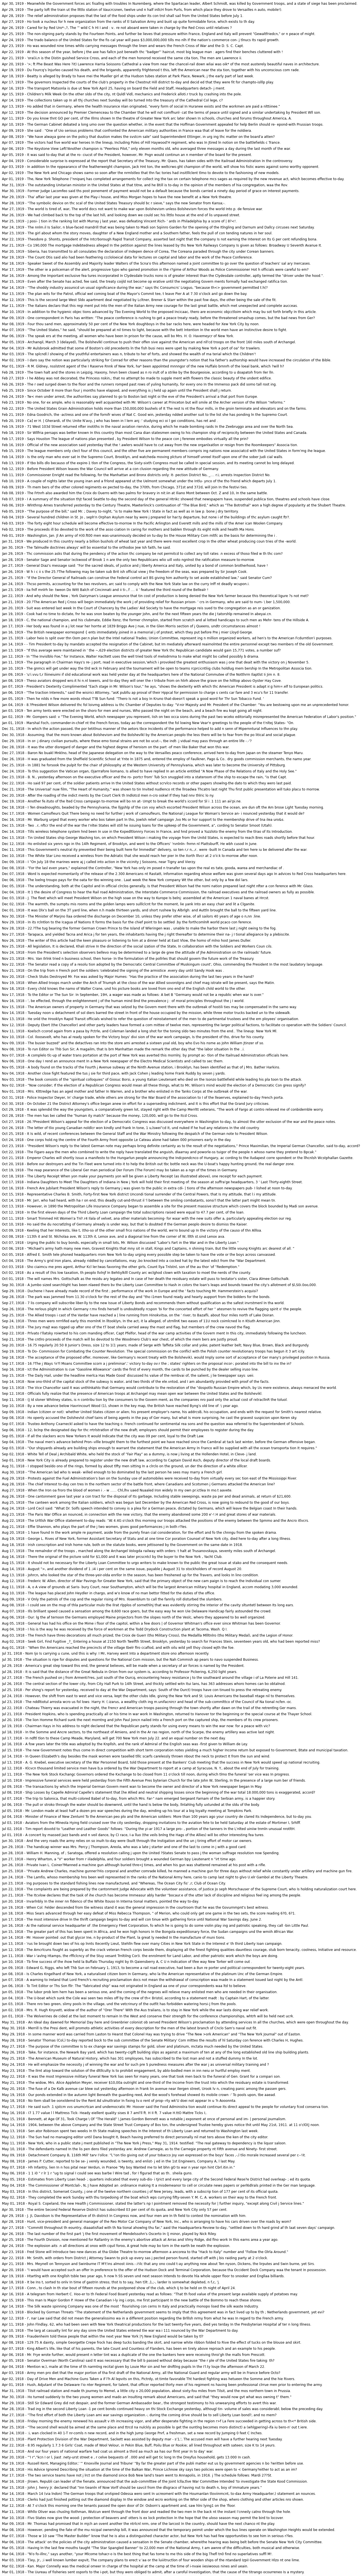

In [149]:
# Convert the date to a datetime object in order to easily manipulate how it is displayed.
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.strftime('%b %d, %Y')

# Plot the data
fig,ax = plt.subplots()
vertical_spacing = 0

for row in data.iterrows():
    t = str(row[1][0])+" - "+str(row[1][1])
    ax.text(0, vertical_spacing, t, fontsize='large')
    vertical_spacing += 0.1

plt.axis('off')
plt.show()

<a id='conclusion'></a>

## Conclusion

Ultimately, despite the data processing steps, the text is still not in a good shape. This is mostly due to poor OCR quality. It seems to us that the OCR results on this archive might make the type of analysis we proposed unviable (following the precept "garbage in, garbage out"). A possible pathway would be downloading the source images and re-running an OCR algorithm, aiming for better results. However, we recognize that running this project in its totality already takes a long time, and processing images would add considerable time and complexity, making it impractical for our purposes. 

One thing seems certain: the Influenza pandemic did not dominate the attention of the news in New York, as it seems to have been overshadowed by geopolitics in general and the First World War in particular. The prevalence of the war news in the newspapers persisted even after its end (November, 1918). However poor the data quality may be, it tells us that the media attention to the pandemic might not have been proportional to the damage it would ultimately cause.

<a id='bibliography'></a>

## Bibliography

* "1918 Pandemic Influenza Historic Timeline". Accessed June 6, 2021. https://www.cdc.gov/flu/pandemic-resources/1918-commemoration/pandemic-timeline-1918.htm


* "About Chronicling America". Accessed June 1, 2021. https://chroniclingamerica.loc.gov/about/


* Butterhof, R., Thomas, D., Yarasavage, N. "Chronicling America". Accessed June 5, 2021. https://collectionsasdata.github.io/facet6/.


* Fuller-Seeley, Kathryn. "Chronicling America: Historic American Newspapers, http://www.loc.gov/chroniclingamerica/index.html. Created and maintained by the National Digital Newspaper Program, jointly sponsored by the Library of Congress and the National Endowment for the Humanities." Reviewed Nov. 15–Dec. 29, 2007, Journal of American History, Volume 95, Issue 2, September 2008, Pages 624–625, https://doi.org/10.2307/25095783


*  Müller, Philipp. “Archives and History: Towards a History of ‘the Use of State Archives’ in the 19th Century.” History of the Human Sciences 26, no. 4 (October 2013): 27–49. https://doi.org/10.1177/0952695113502483.


* "NEH Announces the Winners of the Chronicling America Data Challenge". Accessed June 10, 2021. https://www.neh.gov/news/press-release/2016-07-25


* Taghva, K., T. Nartker, A. Condit and J. Borsack. “Automatic Removal of “ Garbage Strings ” in OCR Text : An Implementation”. Accessed June 27, 2021. http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=C8239B820BE0100794138254D98F8725?doi=10.1.1.81.8901&rep=rep1&type=pdf

